In [1]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
data = pd.read_csv('train.csv', sep = ',')
data.shape

(73799, 14)

In [3]:
data.head(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0


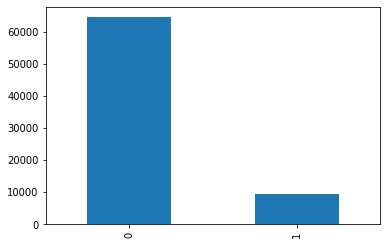

In [4]:
data['default'].value_counts().plot.bar()

In [5]:
data.isnull().sum()

client_id             0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

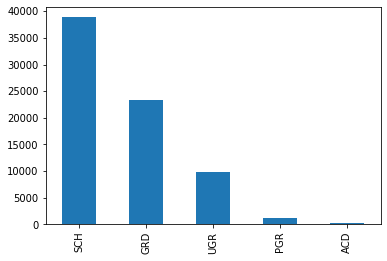

In [6]:
data['education'].value_counts().plot.bar()

In [7]:
(data['education'].isnull().sum()/data.shape[0])*100
# -> процент пропусков совсем маленький (меньше 1%), их можно удалить

0.41599479667746175

In [8]:
data = data.dropna(axis=0)

In [9]:
print('sex', data.sex.unique())
print('car', data.car.unique())
print('car_type', data.car_type.unique())
print('good_work', data.good_work.unique())
print('foreign_passport', data.foreign_passport.unique())
print('default', data.default.unique())
print('education', data.education.unique())
print('home_address', data.home_address.unique())
print('work_address', data.work_address.unique())
print('age', data.age.unique())
print('decline_app_cnt', data.decline_app_cnt.unique())
print('income', data.income.unique())
print('bki_request_cnt', data.bki_request_cnt.unique())

sex ['M' 'F']
car ['Y' 'N']
car_type ['Y' 'N']
good_work [0 1]
foreign_passport ['N' 'Y']
default [0 1]
education ['SCH' 'GRD' 'UGR' 'PGR' 'ACD']
home_address [1 2 3]
work_address [2 3 1]
age [62 59 25 53 48 27 39 50 54 29 32 30 23 37 36 41 28 58 26 45 44 43 56 40
 34 33 67 38 46 42 35 24 61 21 52 55 49 57 31 64 63 51 22 65 47 66 68 60
 69 70 72 71]
decline_app_cnt [ 0  2  1  3  4  6  5  7  8  9 13 11 19 10 22 33 14 12 15 24 16]
income [  18000   19000   30000   10000   15000   28000   45000   24000   60000
   40000   23000   32000   33000    8000   25000   50000   14000   55000
   26000   20000  100000   14800   70000   80000   65000   11000   75000
   35000  200000    9000   27000   15100  130000   21000  350000   22000
   43000   16000    5000   64000    6000   95000   12000   48000   37000
    9600   17000   11500   23400    8500   85000   29000   10500   49000
   13000  160000  150000    6500   16700   90000   25890   77000   47000
   38000   58000   36000   52000   12200   28600 

In [10]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac3f2067d0>,
      dtype=object)

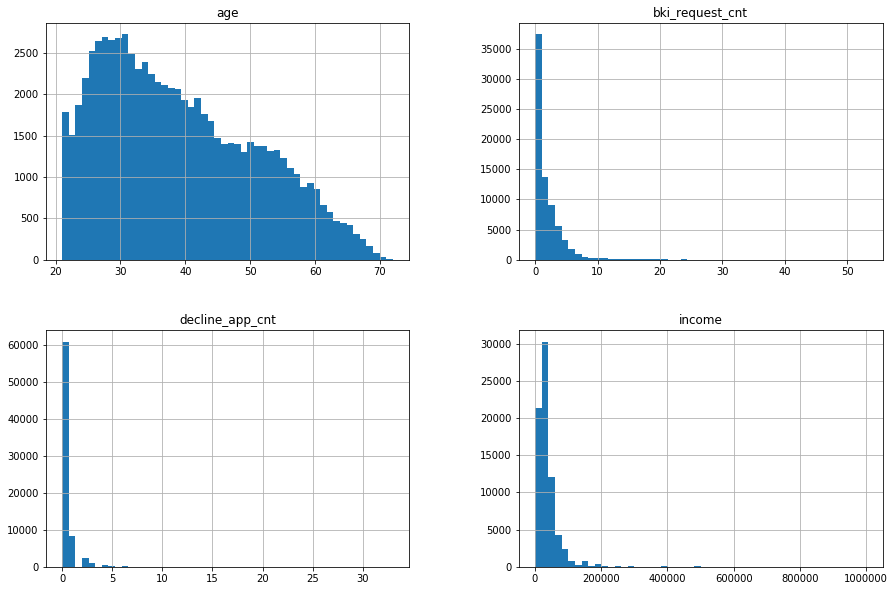

In [11]:
data[num_cols].hist(figsize=(15, 10), bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac433e9510>,
      dtype=object)

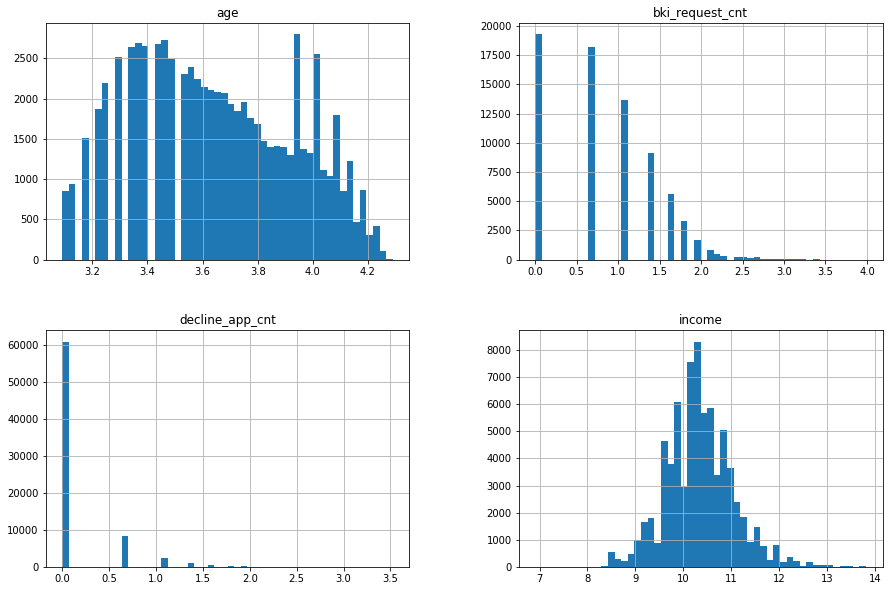

In [12]:
# у графиков большой правый хвост, чтобы сделать рспределение более нормальным, можно логарифмировать эти переменные
# log_data = data[num_cols].copy(deep=True)

for i in num_cols:
    data[i] = data[i].apply(lambda x: np.log(x + 1))
    
data[num_cols].hist(figsize=(15, 10), bins=50)
# -> тогда распределение становится менее смещенным

/Users/natalia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


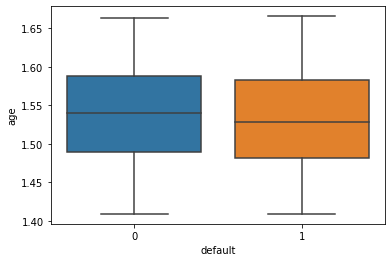

In [13]:
default_clients = data[['default', 'age', 'decline_app_cnt', 'income', 'bki_request_cnt']]
for i in num_cols:
    default_clients[i] = default_clients[i].apply(lambda x: np.log(x + 1))

sns.boxplot(x = 'default', y='age', data=default_clients)

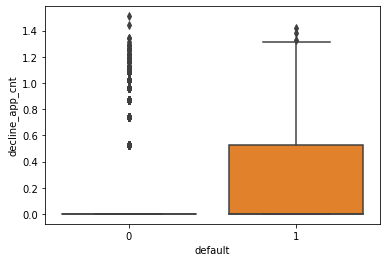

In [14]:
sns.boxplot(x = 'default', y='decline_app_cnt', data=default_clients)

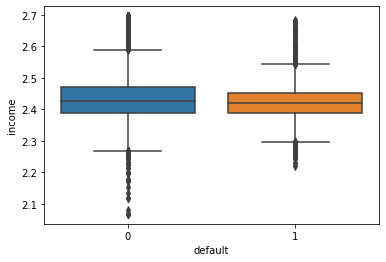

In [15]:
sns.boxplot(x = 'default', y='income', data=default_clients)

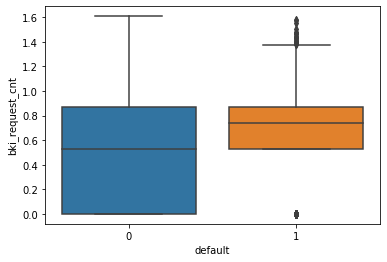

In [16]:
sns.boxplot(x = 'default', y='bki_request_cnt', data=default_clients)

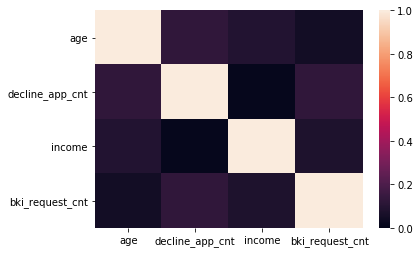

In [17]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

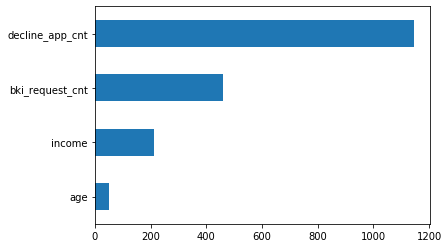

In [18]:
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [19]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [20]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,4.143135,1,1,0.000000,0,0.693147,1,2,9.798183,0,0
1,63161,SCH,0,4.094345,0,0,0.000000,0,1.386294,2,3,9.852247,0,0
2,25887,SCH,1,3.258097,1,0,1.098612,0,0.693147,1,2,10.308986,1,0
3,16222,SCH,0,3.988984,0,0,0.000000,0,1.098612,2,3,9.210440,0,0
4,101655,GRD,1,3.891820,0,0,0.000000,1,0.693147,2,3,10.308986,1,0


In [21]:
label_encoder_edu = LabelEncoder()
data['education'] = label_encoder_edu.fit_transform(data['education'])
print(dict(enumerate(label_encoder_edu.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


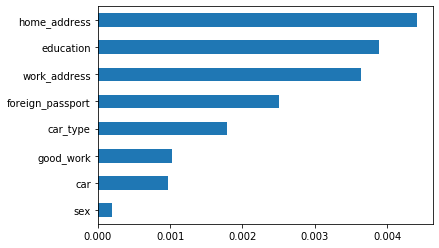

In [22]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [23]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)

In [24]:
X_cat.shape

(73492, 11)

In [25]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(data[num_cols].values)

In [26]:
# Объединяем

X = np.hstack([X_num, data[bin_cols].values, X_cat])
Y = data['default'].values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [28]:
model = LogisticRegression()
model.fit(X_train, y_train)
Y_predicted = model.predict(X_test)

/Users/natalia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [41]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

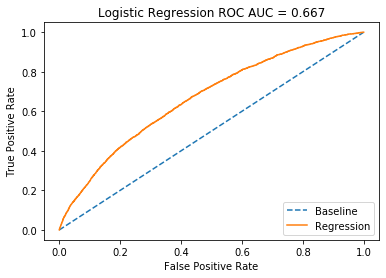

In [42]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [38]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol 1e-3
# чтобы получить оптимальные параметры модели в первом приближении
RANDOM_SEED = 42
model = LogisticRegression(random_state=RANDOM_SEED)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
                {'penalty': ['l1'], 
                 'solver': ['liblinear', 'lbfgs'], 
                 'class_weight':['none', 'balanced'], 
                 'multi_class': ['auto','ovr'], 
                 'max_iter':[iter_],
                 'tol':[epsilon_stop]},
    
                {'penalty': ['l2'], 
                 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                 'class_weight':['none', 'balanced'], 
                 'multi_class': ['auto','ovr'], 
                 'max_iter':[iter_],
                 'tol':[epsilon_stop]},
    
                {'penalty': ['none'], 
                 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
                 'class_weight':['none', 'balanced'], 
                 'multi_class': ['auto','ovr'], 
                 'max_iter':[iter_],
                 'tol':[epsilon_stop]},
            ]

gridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'none'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'saga'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.8722
Precision: 0.3333
Recall: 0.0005
F1: 0.0011


/Users/natalia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
